# Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer

# Handling imbalanced datasets
from imblearn.over_sampling import SMOTE

# Model selection and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Machine Learning models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation metrics
from sklearn.metrics import (confusion_matrix, accuracy_score, f1_score, 
                             recall_score, precision_score, 
                             mean_absolute_error, mean_squared_error, 
                             roc_curve, roc_auc_score)

# Statistical methods
from scipy.stats import mode

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Dataset Load

In [2]:
# Load the CSV file
data = pd.read_csv('/kaggle/input/avped-dataset/AntiVped.csv')
data.head()

,Sequence,molecular \nweight,Theoretical Pi,Extinction \ncoefficient,Half life\n(hours),Instability\n index,Aliphatic\n index,GRAVY,Hydrophobic \nresidue :,Net charge:,Boman Index:\n(Kcal/mol),Protective Antigenic\n Score,Allergenicity,property = 1
0,GKPRPYSPRPTSHPRPIRV,2198.56,12.01,1490.0,30.0,41.15,35.79,-1.579,10.0,5.0,3.65,0.5017,no evidence,1
1,ACYCRIPACIAGERRYGTCIYQGRLWAFCC,3448.09,8.68,10345.0,4.4,55.71,65.33,0.3,53.0,3.0,1.07,0.4636,no evidence,1
2,FLFPLITSFLSKVL,1625.03,8.75,NaN,1.1,16.98,160.00,1.75,64.0,1.0,-1.61,0.4303,no evidence,1
3,SNDIYFNFQR,1303.40,5.55,1490.0,1.9,-6.03,39.00,-1.05,30.0,0.0,3.51,0.5745,strong evidence,1
4,GLFSVLGAVAKHVLPHVVPVIAEKL,2594.18,8.61,NaN,30.0,25.92,159.60,1.224,60.0,1.5,-1.13,0.4590,no evidence,1


# Class Distribution

property = 1
1    2082
0    1804
Name: count, dtype: int64


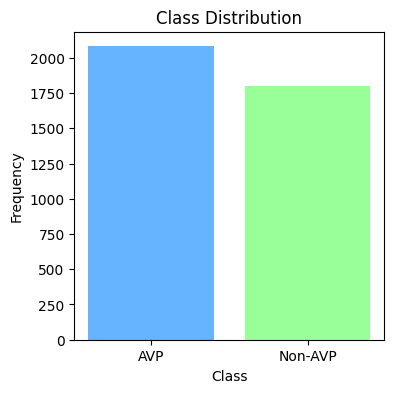

In [3]:
class_counts = data['property = 1'].value_counts()

print(class_counts)

beingsaved = plt.figure(figsize=(4, 4))
colors = ['#66b3ff', '#99ff99']
plt.bar(['AVP', 'Non-AVP'], class_counts.values, color=colors)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
beingsaved.savefig('/kaggle/working/Class_Distribution.png', format='png', dpi=600, bbox_inches="tight")
plt.show()

# Null Values Count

In [4]:
data.isna().sum()

 Sequence                         0
molecular \nweight                5
Theoretical Pi                    5
Extinction \ncoefficient        990
Half life\n(hours)                5
Instability\n index               5
Aliphatic\n index                 5
GRAVY                             7
Hydrophobic \nresidue :         115
Net charge:                     115
Boman Index:\n(Kcal/mol)        116
Protective Antigenic\n Score     19
Allergenicity                     2
property = 1                      0
dtype: int64

# Correlation Matrics¶

/tmp/ipykernel_17/2326518389.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Attributes[column] = label_encoder.fit_transform(Attributes[column])
/tmp/ipykernel_17/2326518389.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Attributes[column] = label_encoder.fit_transform(Attributes[column])
/tmp/ipykernel_17/2326518389.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

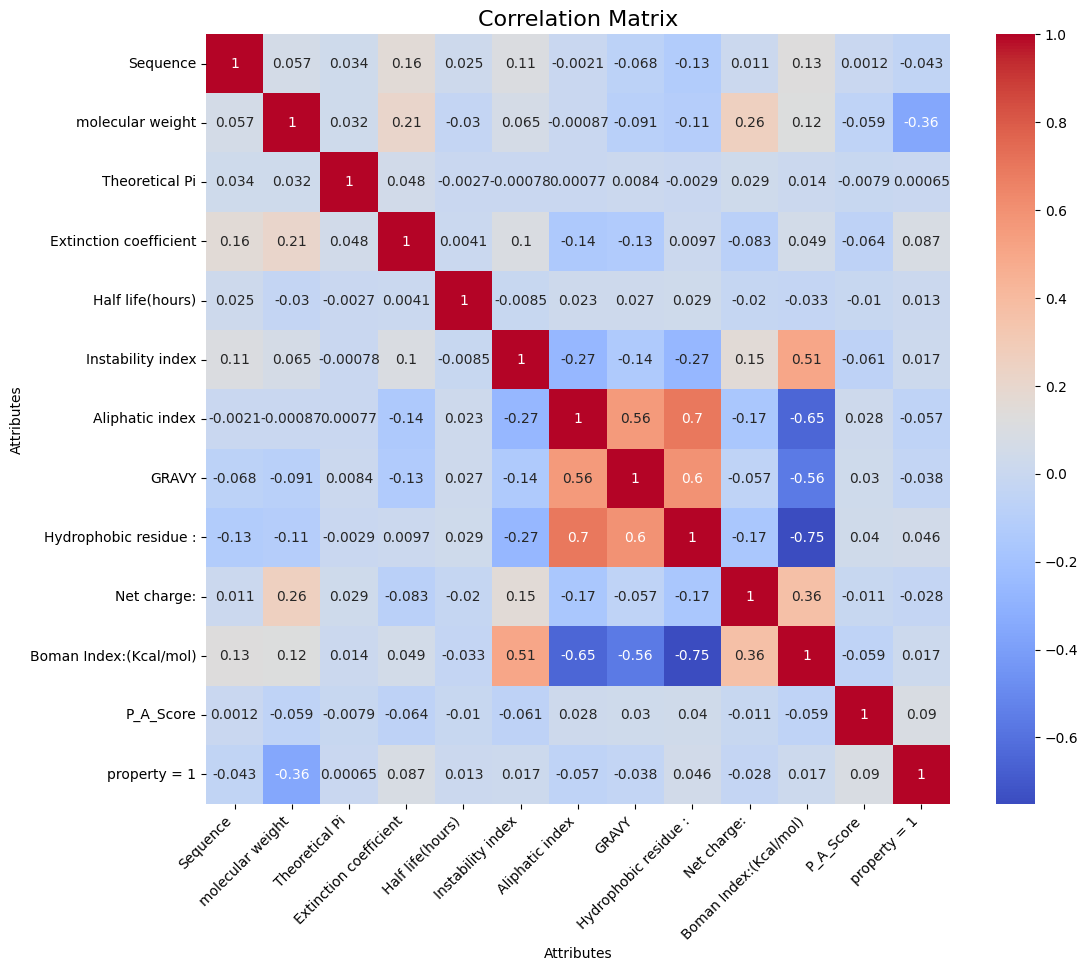

In [5]:
# Clean up the column names
data.columns = data.columns.str.replace('\n', '').str.strip()

# Select the features and labels
Attributes = data[['Sequence','molecular weight', 'Theoretical Pi', 'Extinction coefficient', 'Half life(hours)', 
                   'Instability index', 'Aliphatic index', 'GRAVY', 'Hydrophobic residue :', 
                   'Net charge:', 'Boman Index:(Kcal/mol)', 'Protective Antigenic Score','property = 1']]

# Convert non-numeric columns to numeric using label encoding
label_encoder = LabelEncoder()
for column in Attributes.columns:
    if Attributes[column].dtype == object:
        Attributes[column] = label_encoder.fit_transform(Attributes[column])

# Modify column names
Attributes.rename(columns={'Protective Antigenic Score': 'P_A_Score'}, inplace=True)

# Calculate the correlation matrix
correlation_matrix = Attributes.corr()
beingsaved = plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Set title and labels
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
# Set the axis labels and title
plt.xlabel('Attributes')
plt.ylabel('Attributes')

beingsaved.savefig('/kaggle/working/Correlation Matrix.png', format='png', dpi=600, bbox_inches="tight")
plt.show()

# Machine Learning Models

In [6]:
# Load the CSV file
data = pd.read_csv('/kaggle/input/avped-dataset/AntiVped.csv')

# Convert non-numeric values to NaN for numeric columns
numeric_columns = ['molecular \nweight', 'Theoretical Pi', 'Extinction \ncoefficient', 'Half life\n(hours)', 
                   'Instability\n index', 'Aliphatic\n index', 'GRAVY', 'Hydrophobic \nresidue :', 
                   'Net charge:', 'Boman Index:\n(Kcal/mol)', 'Protective Antigenic\n Score']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Fill missing values for numerical columns with their mean
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Fill missing values for the categorical column 'Allergenicity' with the most frequent value
data['Allergenicity'] = data['Allergenicity'].fillna(data['Allergenicity'].mode()[0])

# Clean up the column names
data.columns = data.columns.str.replace('\n', '').str.strip()

# Encode the 'Allergenicity' column using LabelEncoder
label_encoder = LabelEncoder()
data['Allergenicity'] = label_encoder.fit_transform(data['Allergenicity'])

# Get unique amino acids in the dataset and create encoding
all_amino_acids = set(''.join(data['Sequence'].tolist()))
amino_acid_to_index = {amino_acid: i for i, amino_acid in enumerate(all_amino_acids)}

# Preprocess sequence data using one-hot encoding and pad the sequences
sequences_encoded = []
for sequence in data['Sequence']:
    encoded_sequence = [amino_acid_to_index[amino_acid] for amino_acid in sequence]
    sequences_encoded.append(encoded_sequence)

# Pad the sequences
max_sequence_length = max(len(seq) for seq in sequences_encoded)
sequences_padded = pad_sequences(sequences_encoded, maxlen=max_sequence_length, padding='post')
data['Sequence_Encoded'] = sequences_padded.tolist()

# Ensure the correct target column name here
y = data['property = 1']  # Replace with the actual name of the target column

# Select the features for X (excluding 'Sequence_Encoded' as it's processed separately)
X = data[['Sequence_Encoded', 'molecular weight', 'Extinction coefficient', 'Theoretical Pi', 'Half life(hours)', 
          'Instability index', 'Aliphatic index', 'GRAVY', 'Hydrophobic residue :', 
          'Net charge:', 'Boman Index:(Kcal/mol)', 'Protective Antigenic Score', 'Allergenicity']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert sequence data to numpy arrays
X_train_sequences = np.array(X_train['Sequence_Encoded'].tolist())
X_test_sequences = np.array(X_test['Sequence_Encoded'].tolist())

# Flatten the sequence data
X_train_sequences_flat = X_train_sequences.reshape(X_train_sequences.shape[0], -1)
X_test_sequences_flat = X_test_sequences.reshape(X_test_sequences.shape[0], -1)

# Combine the flattened sequence data with other features (drop the 'Sequence_Encoded' column)
X_train_combined = np.hstack((X_train_sequences_flat, X_train.drop(columns=['Sequence_Encoded']).values))
X_test_combined = np.hstack((X_test_sequences_flat, X_test.drop(columns=['Sequence_Encoded']).values))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined, y_train)

# Define the classifiers
classifiers = {
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Neural Network': MLPClassifier()
}



#  Machine Learning Models Evaluation

Model: SVM
Accuracy: 0.7005141388174807
Confusion Matrix:
[[212 133]
 [100 333]]
F1 Score: 0.7408231368186874
Recall: 0.76905311778291
Precision: 0.7145922746781116
Mean Absolute Error: 0.2994858611825193
Root Mean Squared Error: 0.5472530138633495
ROC AUC Score: 0.6917729357030491


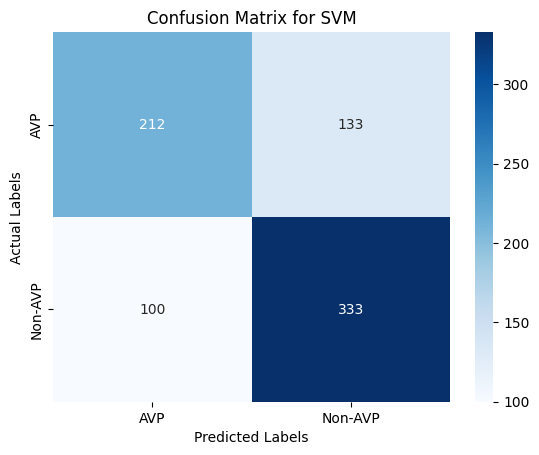

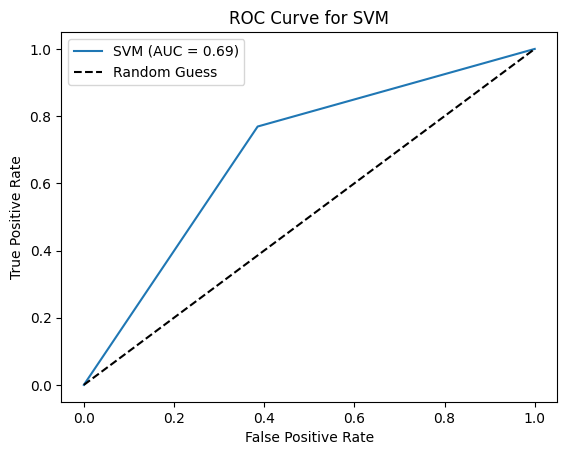

---------------------------------------
Model: Decision Tree
Accuracy: 0.7455012853470437
Confusion Matrix:
[[238 107]
 [ 91 342]]
F1 Score: 0.7755102040816326
Recall: 0.789838337182448
Precision: 0.7616926503340757
Mean Absolute Error: 0.2544987146529563
Root Mean Squared Error: 0.5044786562907854
ROC AUC Score: 0.739846704823108


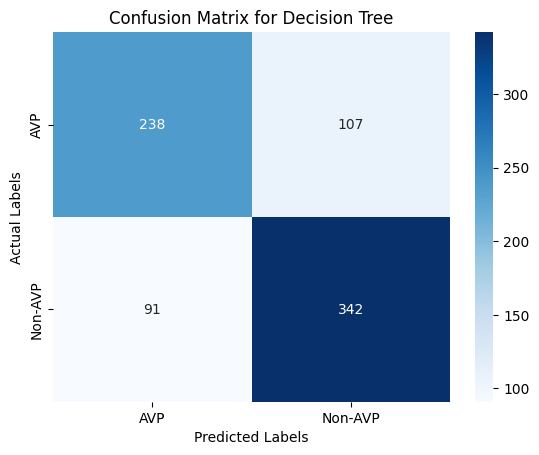

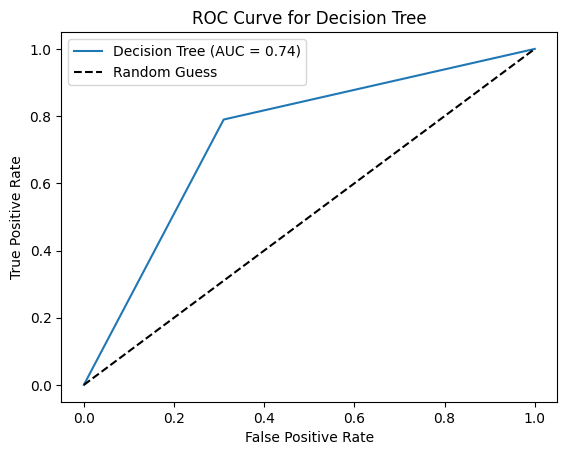

---------------------------------------
Model: Random Forest
Accuracy: 0.8277634961439588
Confusion Matrix:
[[264  81]
 [ 53 380]]
F1 Score: 0.8501118568232662
Recall: 0.8775981524249422
Precision: 0.824295010845987
Mean Absolute Error: 0.17223650385604114
Root Mean Squared Error: 0.41501385983607963
ROC AUC Score: 0.8214077718646451


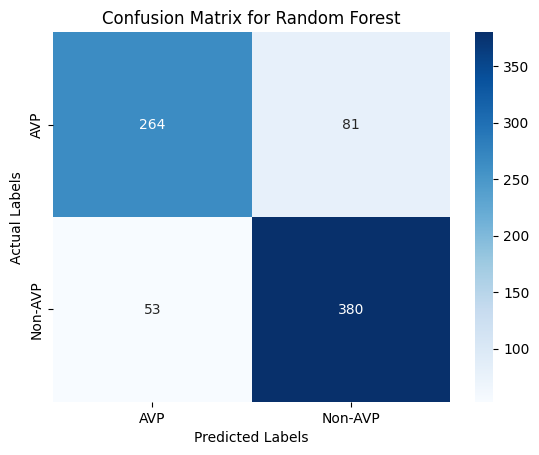

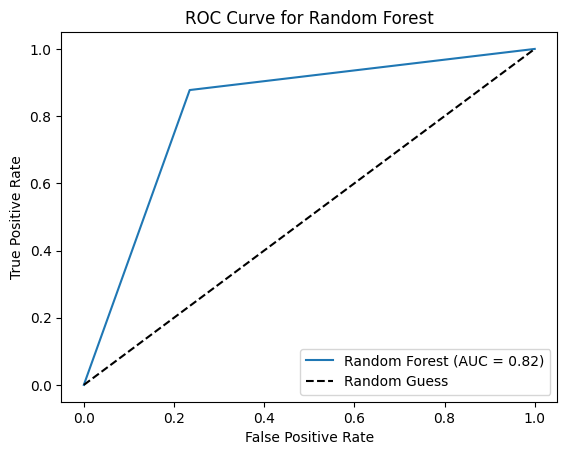

---------------------------------------
Model: Logistic Regression


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7146529562982005
Confusion Matrix:
[[235 110]
 [112 321]]
F1 Score: 0.7430555555555556
Recall: 0.7413394919168591
Precision: 0.7447795823665894
Mean Absolute Error: 0.2853470437017995
Root Mean Squared Error: 0.534178849919949
ROC AUC Score: 0.7112494561033571


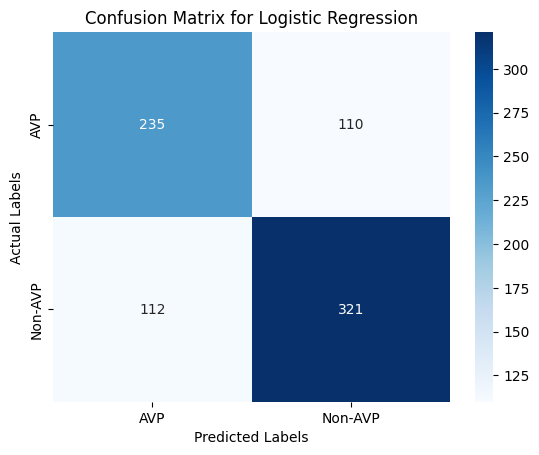

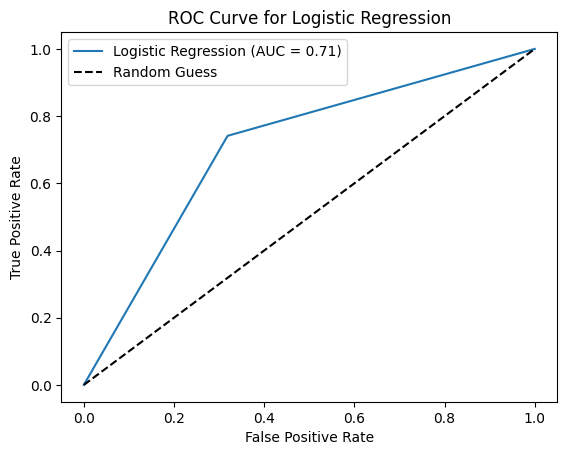

---------------------------------------
Model: Gradient Boosting
Accuracy: 0.8187660668380463
Confusion Matrix:
[[270  75]
 [ 66 367]]
F1 Score: 0.8388571428571429
Recall: 0.8475750577367206
Precision: 0.830316742081448
Mean Absolute Error: 0.18123393316195371
Root Mean Squared Error: 0.4257157891856417
ROC AUC Score: 0.8150918766944473


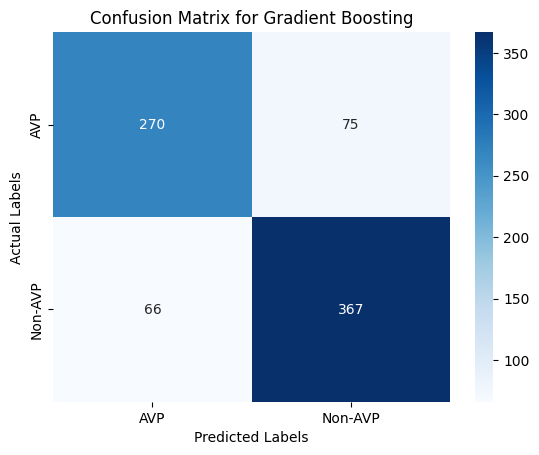

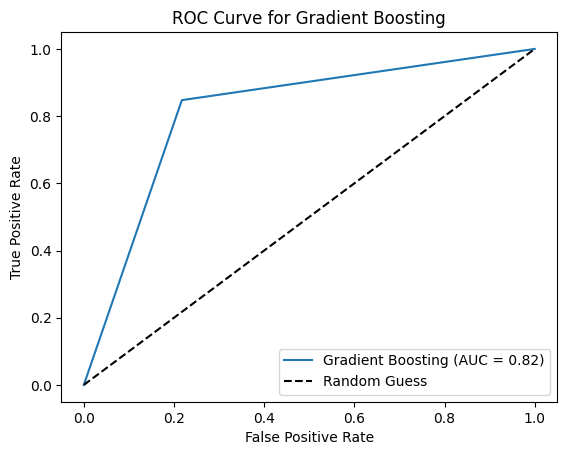

---------------------------------------
Model: K-Nearest Neighbors
Accuracy: 0.7609254498714653
Confusion Matrix:
[[264  81]
 [105 328]]
F1 Score: 0.7790973871733966
Recall: 0.7575057736720554
Precision: 0.8019559902200489
Mean Absolute Error: 0.2390745501285347
Root Mean Squared Error: 0.48895250293718173
ROC AUC Score: 0.7613615824882016


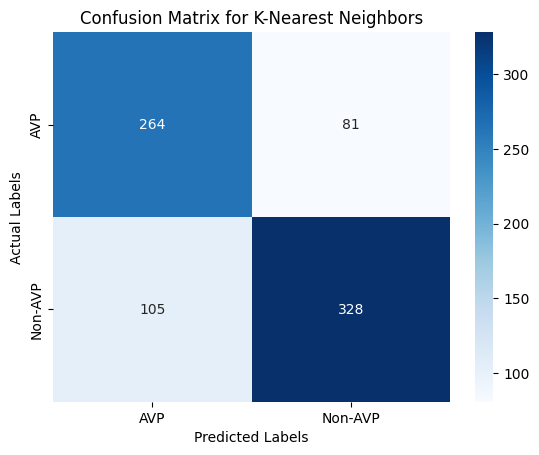

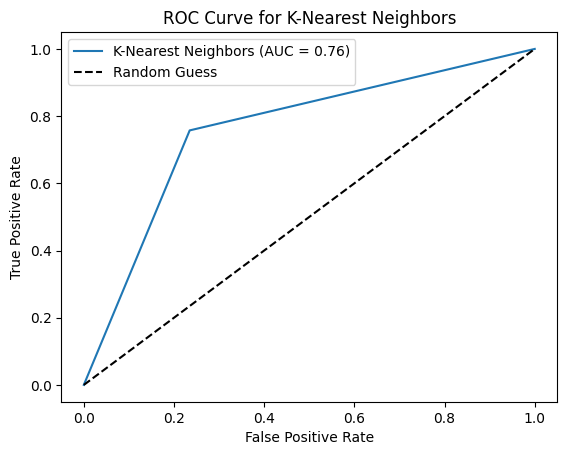

---------------------------------------
Model: Neural Network
Accuracy: 0.6799485861182519
Confusion Matrix:
[[287  58]
 [191 242]]
F1 Score: 0.6603001364256481
Recall: 0.558891454965358
Precision: 0.8066666666666666
Mean Absolute Error: 0.32005141388174807
Root Mean Squared Error: 0.565730867004575
ROC AUC Score: 0.6953877564681862


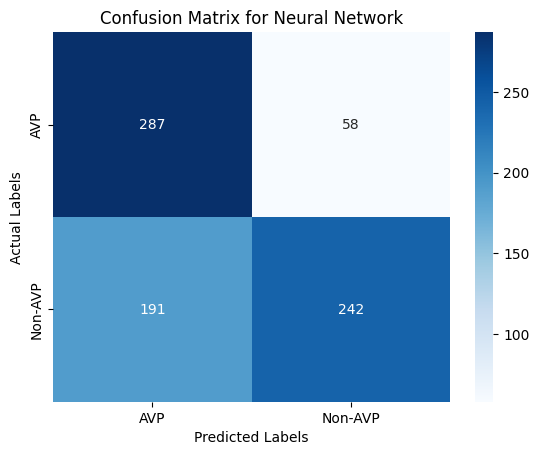

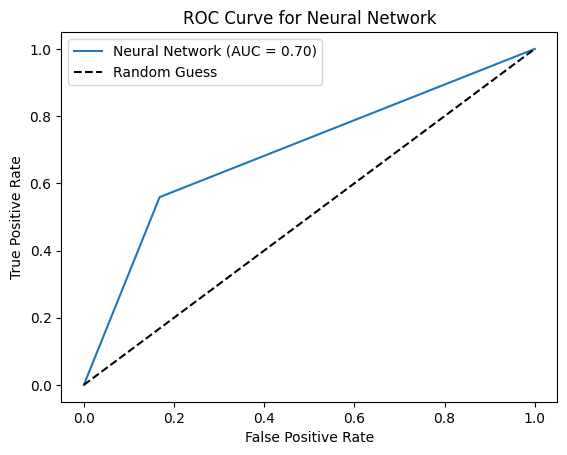

---------------------------------------


In [7]:

# Train and evaluate each classifier
for name, classifier in classifiers.items():
    print(f"Model: {name}")
    
    classifier.fit(X_train_balanced, y_train_balanced)
    y_pred = classifier.predict(X_test_combined)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix:\n{cm}")

    # Calculate F1 score, precision, recall, etc.
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"ROC AUC Score: {roc_auc}")

    # Create a heatmap of the confusion matrix
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=["AVP", "Non-AVP"], yticklabels=["AVP", "Non-AVP"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend()
    plt.show()

    print("---------------------------------------")

# Proposed Ensemble Model

In [8]:

# Load the CSV file
data = pd.read_csv('/kaggle/input/avped-dataset/AntiVped.csv')

# Convert non-numeric values to NaN for numeric columns
numeric_columns = ['molecular \nweight', 'Theoretical Pi', 'Extinction \ncoefficient', 
                   'Half life\n(hours)', 'Instability\n index', 'Aliphatic\n index', 
                   'GRAVY', 'Hydrophobic \nresidue :', 'Net charge:', 
                   'Boman Index:\n(Kcal/mol)', 'Protective Antigenic\n Score']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Fill missing values for numerical columns with their mean
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Fill missing values for the categorical column 'Allergenicity' with the most frequent value
data['Allergenicity'] = data['Allergenicity'].fillna(data['Allergenicity'].mode()[0])

# Clean up the column names
data.columns = data.columns.str.replace('\n', '').str.strip()

# Print the cleaned column names for verification
print("Cleaned Column Names:", data.columns.tolist())

# Encode the 'Allergenicity' column using LabelEncoder
label_encoder = LabelEncoder()
data['Allergenicity'] = label_encoder.fit_transform(data['Allergenicity'])

# Get unique amino acids in the dataset and create encoding
all_amino_acids = set(''.join(data['Sequence'].tolist()))
amino_acid_to_index = {amino_acid: i for i, amino_acid in enumerate(all_amino_acids)}

# Preprocess sequence data using one-hot encoding and pad the sequences
sequences_encoded = []
for sequence in data['Sequence']:
    encoded_sequence = [amino_acid_to_index[amino_acid] for amino_acid in sequence]
    sequences_encoded.append(encoded_sequence)

# Pad the sequences
max_sequence_length = max(len(seq) for seq in sequences_encoded)
sequences_padded = pad_sequences(sequences_encoded, maxlen=max_sequence_length, padding='post')
data['Sequence_Encoded'] = sequences_padded.tolist()

# Check the columns before splitting
print("DataFrame Columns Before Splitting:", data.columns.tolist())

# Split the dataset into features (X) and target label (y)
try:
    X = data[['Sequence_Encoded', 'molecularweight', 'Extinctioncoefficient', 'TheoreticalPi', 
              'Halflife(hours)', 'Instabilityindex', 'Aliphaticindex', 'GRAVY', 
              'Hydrophobicresidue:', 'Netcharge:', 'BomanIndex:(Kcal/mol)', 
              'ProtectiveAntigenicScore', 'Allergenicity']]
    y = data['property = 1']
except KeyError as e:
    print(f"KeyError: {e}. Check the column names.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert sequence data to numpy arrays
X_train_sequences = np.array(X_train['Sequence_Encoded'].tolist())
X_test_sequences = np.array(X_test['Sequence_Encoded'].tolist())

# Flatten the sequence data
X_train_sequences_flat = X_train_sequences.reshape(X_train_sequences.shape[0], -1)
X_test_sequences_flat = X_test_sequences.reshape(X_test_sequences.shape[0], -1)

# Combine the flattened sequence data with other features
X_train_combined = np.hstack((X_train_sequences_flat, X_train.drop(columns=['Sequence_Encoded'])))
X_test_combined = np.hstack((X_test_sequences_flat, X_test.drop(columns=['Sequence_Encoded'])))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined, y_train)

# Define the classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Train classifiers and store predictions
predictions = {}
for name, classifier in classifiers.items():
    classifier.fit(X_train_balanced, y_train_balanced)
    y_pred = classifier.predict(X_test_combined)  # Use the original test set
    predictions[name] = y_pred

# Custom ensemble method using majority voting
def custom_ensemble(predictions):
    # Stack predictions into a 2D array
    pred_array = np.array(list(predictions.values())).T
    # Use mode to find the most common prediction for each instance
    ensemble_predictions = mode(pred_array, axis=1)[0].flatten()
    return ensemble_predictions

# Get ensemble predictions
ensemble_predictions = custom_ensemble(predictions)


Cleaned Column Names: ['Sequence', 'molecular weight', 'Theoretical Pi', 'Extinction coefficient', 'Half life(hours)', 'Instability index', 'Aliphatic index', 'GRAVY', 'Hydrophobic residue :', 'Net charge:', 'Boman Index:(Kcal/mol)', 'Protective Antigenic Score', 'Allergenicity', 'property = 1']
DataFrame Columns Before Splitting: ['Sequence', 'molecular weight', 'Theoretical Pi', 'Extinction coefficient', 'Half life(hours)', 'Instability index', 'Aliphatic index', 'GRAVY', 'Hydrophobic residue :', 'Net charge:', 'Boman Index:(Kcal/mol)', 'Protective Antigenic Score', 'Allergenicity', 'property = 1', 'Sequence_Encoded']
KeyError: "['molecularweight', 'Extinctioncoefficient', 'TheoreticalPi', 'Halflife(hours)', 'Instabilityindex', 'Aliphaticindex', 'Hydrophobicresidue:', 'Netcharge:', 'BomanIndex:(Kcal/mol)', 'ProtectiveAntigenicScore'] not in index". Check the column names.


# Proposed Ensemble Model Evaluation

Ensemble Accuracy: 0.8367609254498715
F1 Score: 0.8571428571428571
Recall: 0.8799076212471132
Precision: 0.8355263157894737
Mean Absolute Error: 0.16323907455012854
Root Mean Squared Error: 0.40402855660228837
ROC AUC Score: 0.8312581584496435
Confusion Matrix:
[[270  75]
 [ 52 381]]


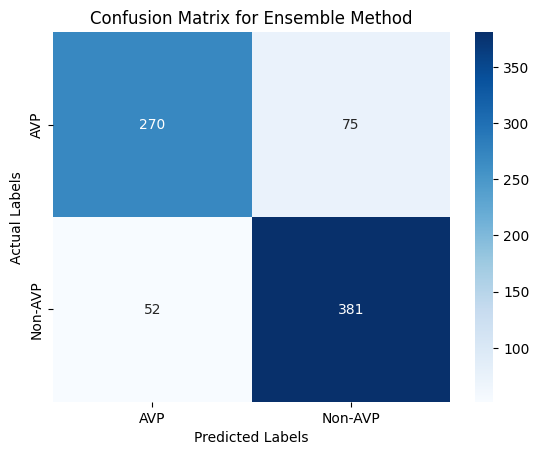

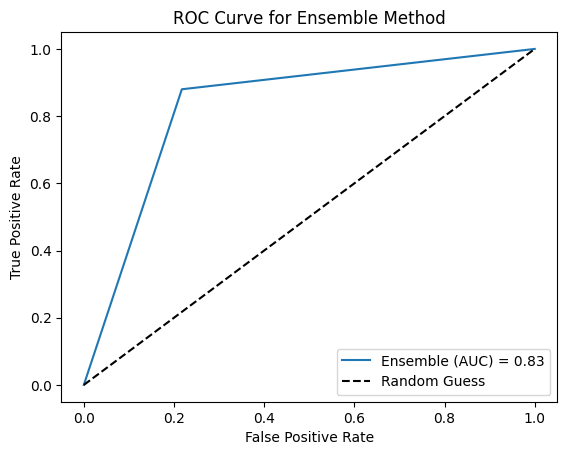

In [9]:

# Evaluate ensemble accuracy
accuracy = accuracy_score(y_test, ensemble_predictions)
print(f"Ensemble Accuracy: {accuracy}")

# Create a confusion matrix
cm = confusion_matrix(y_test, ensemble_predictions)

# Calculate F1 score
f1 = f1_score(y_test, ensemble_predictions)
print(f"F1 Score: {f1}")

# Calculate recall
recall = recall_score(y_test, ensemble_predictions)
print(f"Recall: {recall}")

# Calculate precision
precision = precision_score(y_test, ensemble_predictions)
print(f"Precision: {precision}")

# Calculate mean absolute error
mae = mean_absolute_error(y_test, ensemble_predictions)
print(f"Mean Absolute Error: {mae}")

# Calculate root mean squared error
rmse = mean_squared_error(y_test, ensemble_predictions, squared=False)
print(f"Root Mean Squared Error: {rmse}")

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, ensemble_predictions)
print(f"ROC AUC Score: {roc_auc}")

print(f"Confusion Matrix:\n{cm}")

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["AVP", "Non-AVP"], yticklabels=["AVP", "Non-AVP"])

# Set the axis labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix for Ensemble Method")
plt.show()


# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, ensemble_predictions)

# Plot ROC curve
plt.plot(fpr, tpr, label='Ensemble (AUC) = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ensemble Method')
plt.legend()
plt.show()